In [1]:
import warnings, os
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from random import randint
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Convolution2D
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, RMSprop
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
faces = np.moveaxis(np.load('../input/face_images.npz')['face_images'], -1, 0)
faces.shape

(7049, 96, 96)

In [4]:
landmarks = pd.read_csv('../input/facial_keypoints.csv')
landmarks.shape

(7049, 30)

In [5]:
landmarks.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [6]:
prediction_fields = list(landmarks)[:4]
print('Columns for eye detection:\n', prediction_fields)

Columns for eye detection:
 ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y']


In [7]:
cols_not_null = landmarks['left_eye_center_x'].notna() 
for i in prediction_fields[1:]:
    cols_not_null = cols_not_null & landmarks[i].notna()
is_select = np.nonzero(cols_not_null)[0]
is_select.shape

(7033,)

In [8]:
Y = np.zeros((is_select.shape[0], len(prediction_fields)))
for i in range(len(prediction_fields)):
    Y[:, i] = landmarks[prediction_fields[i]][is_select] / faces.shape[1]
Y.shape

(7033, 4)

In [9]:
X = np.zeros((is_select.shape[0], faces.shape[1], faces.shape[1], 1))
X[:, :, :, 0] = faces[is_select, :, :] / 255.0
X.shape

(7033, 96, 96, 1)

In [10]:
def get_coordinates(arr, scale = 96):
    x, y = [], []
    for i in range(len(arr)):
        if i % 2 == 0:
            x.append(arr[i] * scale)
        else:
            y.append(arr[i]* scale)
    return x, y

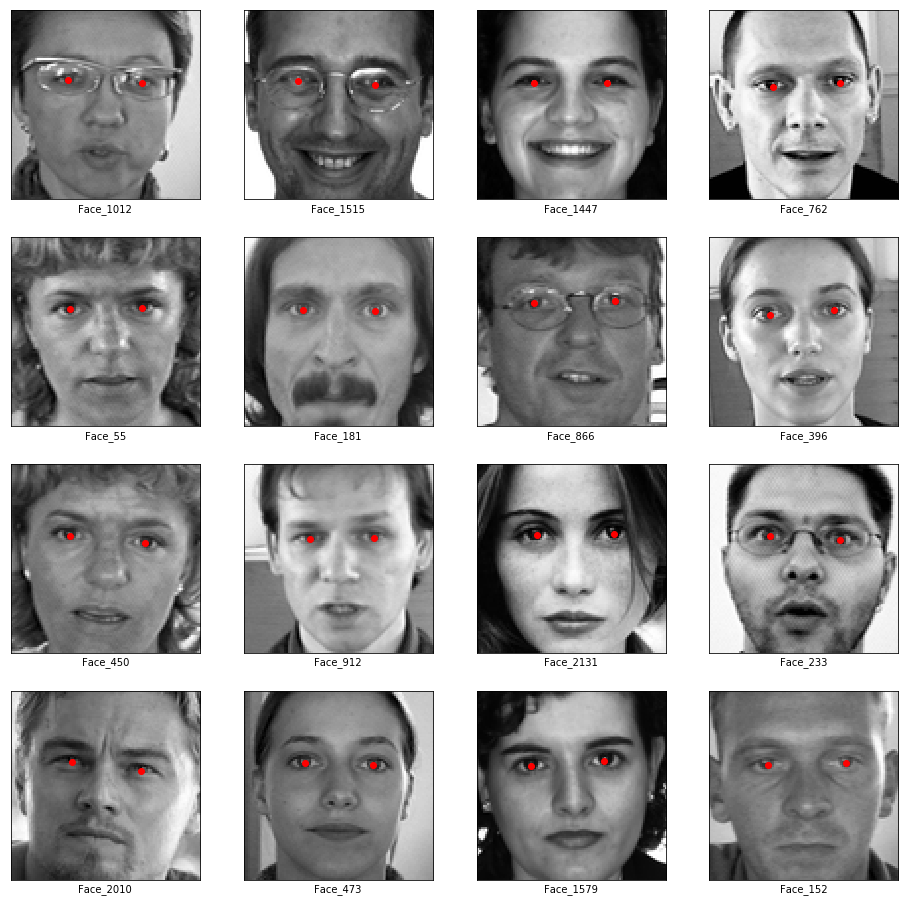

In [11]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    index = randint(0, 2167)
    img = X[index].reshape(96, 96)
    landmark_x, landmark_y = get_coordinates(Y[index])
    ax.imshow(img, cmap = 'gray')
    ax.scatter(landmark_x, landmark_y, c = 'r')
    ax.set_xlabel('Face_' + str(index))
plt.show()

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((6329, 96, 96, 1), (704, 96, 96, 1), (6329, 4), (704, 4))

## Model 1

In [13]:
model_1 = Sequential([
    Conv2D(16, (3, 3), padding = 'same', activation = 'tanh', input_shape = (96, 96, 1)),
    MaxPooling2D(2, 2),
    Dropout(rate = 0.75),
    Conv2D(32, (3, 3), padding = 'same', activation = 'tanh', input_shape = (96, 96, 1)),
    MaxPooling2D(2, 2),
    Dropout(rate = 0.75),
    Flatten(),
    Dense(256, activation = 'tanh'),
    Dropout(rate = 0.75),
    Dense(len(prediction_fields), activation = 'sigmoid')
])

model_1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)  

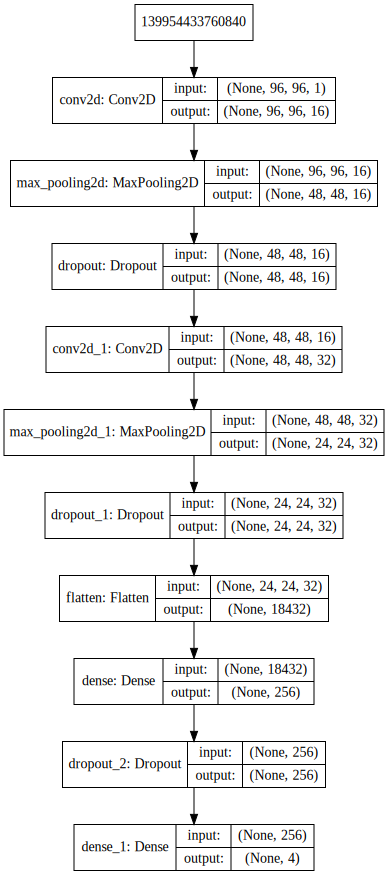

In [14]:
SVG(model_to_dot(model_1, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [15]:
model_1.compile(
    loss = 'mean_squared_error',
    optimizer = SGD(
        lr = 0.1,
        decay = 1e-6,
        momentum = 0.9,
        nesterov = True
    ),
    metrics = ['accuracy']
)

Instructions for updating:
Use tf.cast instead.


In [16]:
history = model_1.fit(X_train, Y_train, batch_size = 128, epochs = 8, validation_data = (X_test, Y_test), verbose = 1)

Train on 6329 samples, validate on 704 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/8
6329/6329 [==============================] - 3s 405us/sample - loss: 0.0142 - acc: 0.9512 - val_loss: 0.0245 - val_acc: 0.3125
Epoch 2/8
6329/6329 [==============================] - 1s 145us/sample - loss: 0.0035 - acc: 0.9953 - val_loss: 0.0060 - val_acc: 0.9986
Epoch 3/8
6329/6329 [==============================] - 1s 147us/sample - loss: 0.0026 - acc: 0.9953 - val_loss: 0.0036 - val_acc: 0.9986
Epoch 4/8
6329/6329 [==============================] - 1s 142us/sample - loss: 0.0021 - acc: 0.9953 - val_loss: 0.0029 - val_acc: 0.9986
Epoch 5/8
6329/6329 [==============================] - 1s 143us/sample - loss: 0.0019 - acc: 0.9953 - val_loss: 0.0024 - val_acc: 0.9986
Epoch 6/8
6329/6329 [==============================] - 1s 143us/sample - loss: 0.0017 - acc: 0.9953 - val_loss: 0.0016 - val_acc: 0.9986
Epoch 7/8
6329/6329 [==============================] - 1s 141us/sample - loss: 0.00

In [17]:
model_1.evaluate(X_test, Y_test, verbose = 1)

704/704 [==============================] - 0s 107us/sample - loss: 0.0015 - acc: 0.9986


[0.0014895344290628352, 0.99857956]

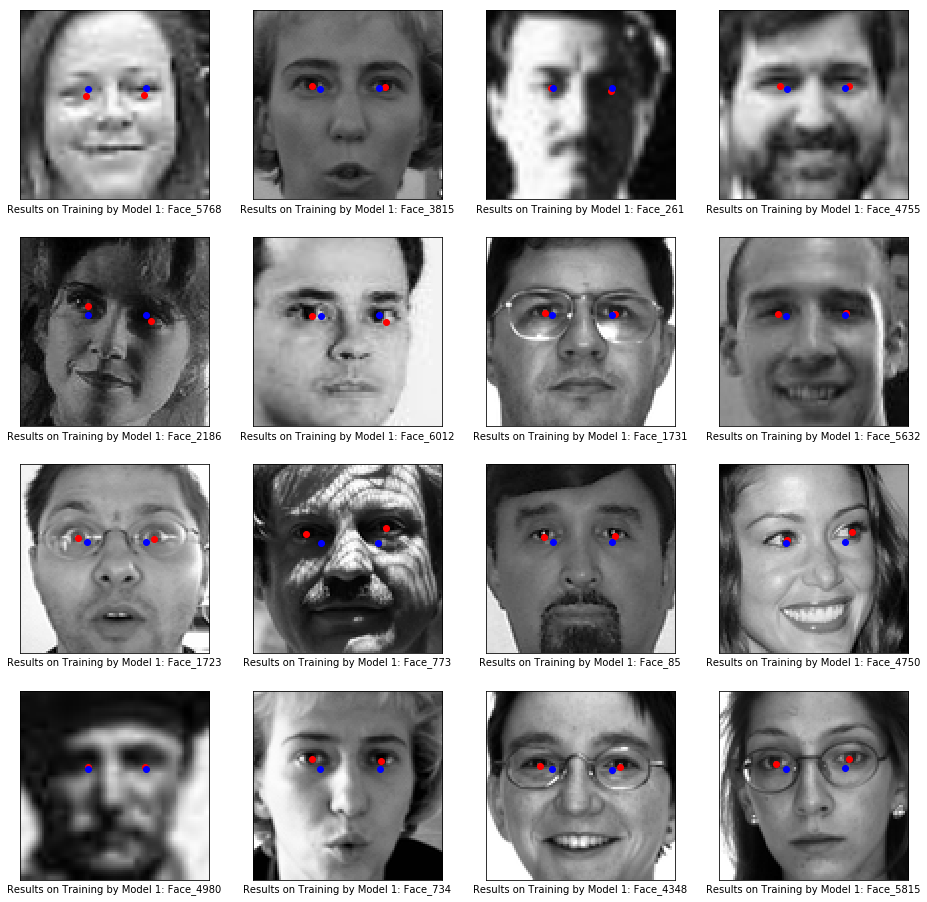

In [18]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    index = randint(0, 6329)
    img = X_train[index].reshape(96, 96)
    landmark_x_original, landmark_y_original = get_coordinates(Y_train[index])
    landmark_x, landmark_y = get_coordinates(model_1.predict(X_train[index].reshape(1, 96, 96, 1))[0])
    ax.imshow(img, cmap = 'gray')
    ax.scatter(landmark_x_original, landmark_y_original, c = 'r')
    ax.scatter(landmark_x, landmark_y, c = 'b')
    ax.set_xlabel('Results on Training by Model 1: Face_' + str(index))
plt.show()

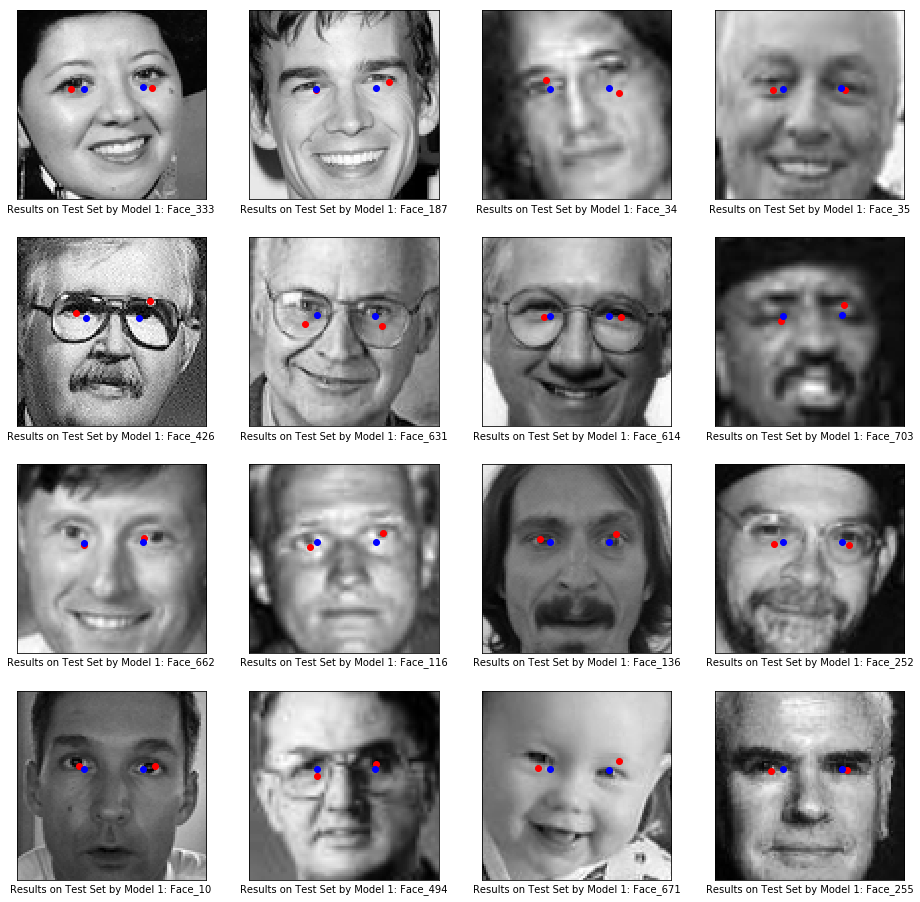

In [19]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    index = randint(0, 704)
    img = X_test[index].reshape(96, 96)
    landmark_x_original, landmark_y_original = get_coordinates(Y_train[index])
    landmark_x, landmark_y = get_coordinates(model_1.predict(X_test[index].reshape(1, 96, 96, 1))[0])
    ax.imshow(img, cmap = 'gray')
    ax.scatter(landmark_x_original, landmark_y_original, c = 'r')
    ax.scatter(landmark_x, landmark_y, c = 'b')
    ax.set_xlabel('Results on Test Set by Model 1: Face_' + str(index))
plt.show()

In [20]:
model_1.save('model_1.h5')

## Model 2

In [21]:
model_2 = Sequential([
    BatchNormalization(input_shape = (96, 96, 1)),
    
    Conv2D(24, (5, 5), padding = 'same', activation = 'relu', input_shape = (96, 96, 1)),
    MaxPooling2D(2, 2, padding = 'valid'),
    Dropout(rate = 0.75),
    
    Conv2D(36, (5, 5), activation = 'relu'),
    MaxPooling2D(2, 2, padding = 'valid'),
    Dropout(rate = 0.75),
    
    Conv2D(48, (5, 5), activation = 'relu'),
    MaxPooling2D(2, 2, padding = 'valid'),
    Dropout(rate = 0.75),
    
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D(2, 2, padding = 'valid'),
    Dropout(rate = 0.75),
    
    Conv2D(64, (3, 3), activation = 'relu'),
    GlobalAveragePooling2D(),
    Dropout(rate = 0.75),
    
    Dense(500, activation = 'relu'),
    Dropout(rate = 0.75),
    Dense(90, activation = 'relu'),
    Dropout(rate = 0.75),
    Dense(4),
])

In [22]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v1 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 24)        624       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 24)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 48, 48, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 36)        21636     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 36)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 22, 22, 36)        0         
__________

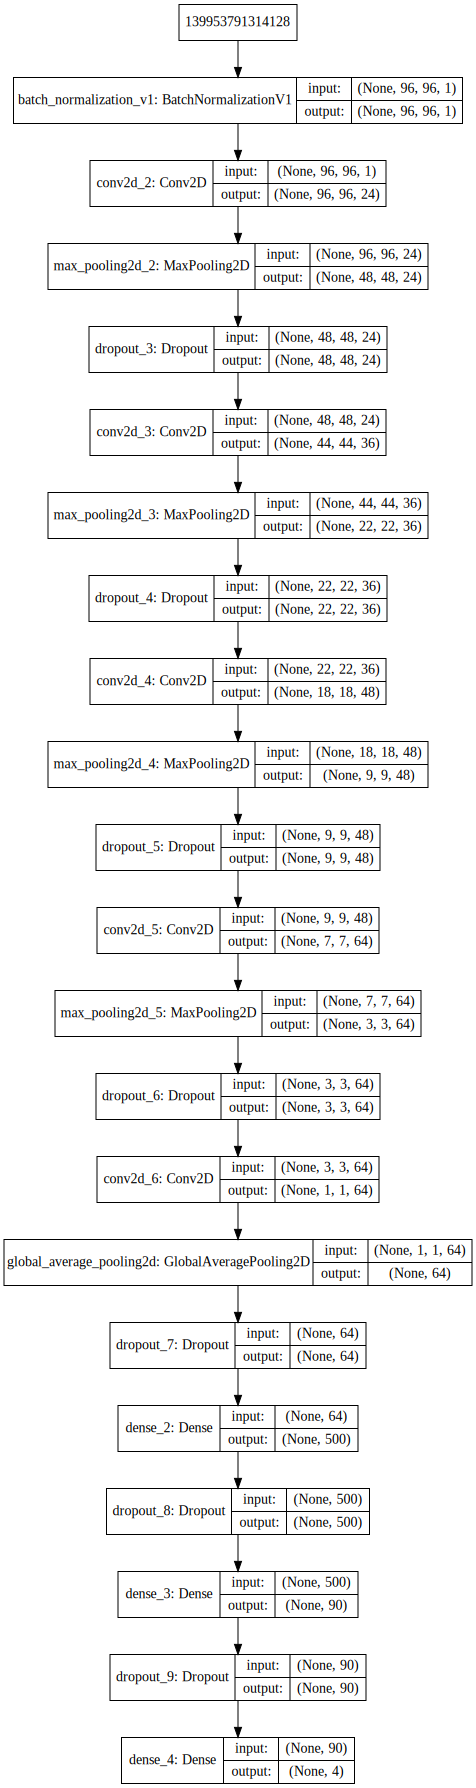

In [23]:
SVG(model_to_dot(model_2, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [24]:
model_2.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['accuracy'])

In [25]:
history_2 = model_2.fit(
    X_train, Y_train,
    validation_data = (
        X_test,
        Y_test
    ),
    batch_size = 20,
    epochs = 5,
    shuffle = True,
    verbose = 1
)

Train on 6329 samples, validate on 704 samples
Epoch 1/5
6329/6329 [==============================] - 4s 580us/sample - loss: 0.5670 - acc: 0.7796 - val_loss: 0.0021 - val_acc: 0.9986
Epoch 2/5
6329/6329 [==============================] - 3s 465us/sample - loss: 0.0049 - acc: 0.9953 - val_loss: 9.4060e-04 - val_acc: 0.9986
Epoch 3/5
6329/6329 [==============================] - 3s 467us/sample - loss: 0.0016 - acc: 0.9953 - val_loss: 9.2494e-04 - val_acc: 0.9986
Epoch 4/5
6329/6329 [==============================] - 3s 463us/sample - loss: 0.0012 - acc: 0.9953 - val_loss: 9.1185e-04 - val_acc: 0.9986
Epoch 5/5
6329/6329 [==============================] - 3s 465us/sample - loss: 0.0011 - acc: 0.9953 - val_loss: 9.2750e-04 - val_acc: 0.9986


In [26]:
model_2.evaluate(X_test, Y_test, verbose = 1)

704/704 [==============================] - 0s 145us/sample - loss: 9.2750e-04 - acc: 0.9986


[0.0009274989953899586, 0.99857956]

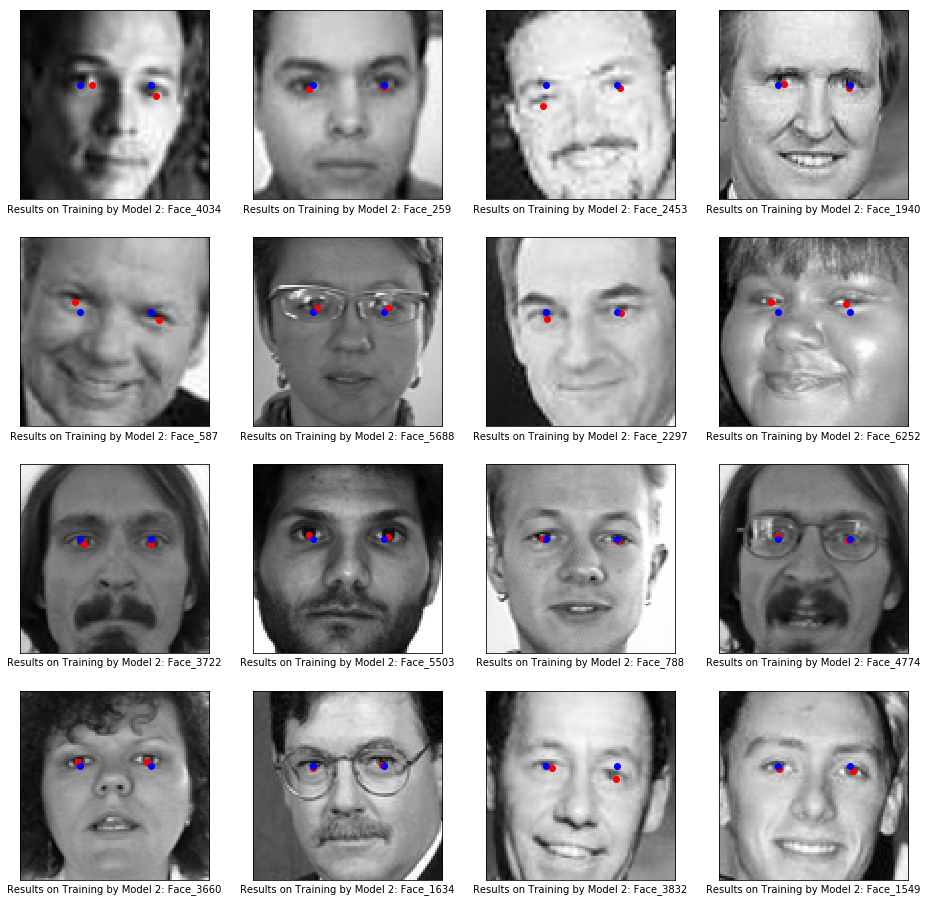

In [27]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    index = randint(0, 6329)
    img = X_train[index].reshape(96, 96)
    landmark_x_original, landmark_y_original = get_coordinates(Y_train[index])
    landmark_x, landmark_y = get_coordinates(model_2.predict(X_train[index].reshape(1, 96, 96, 1))[0])
    ax.imshow(img, cmap = 'gray')
    ax.scatter(landmark_x_original, landmark_y_original, c = 'r')
    ax.scatter(landmark_x, landmark_y, c = 'b')
    ax.set_xlabel('Results on Training by Model 2: Face_' + str(index))
plt.show()

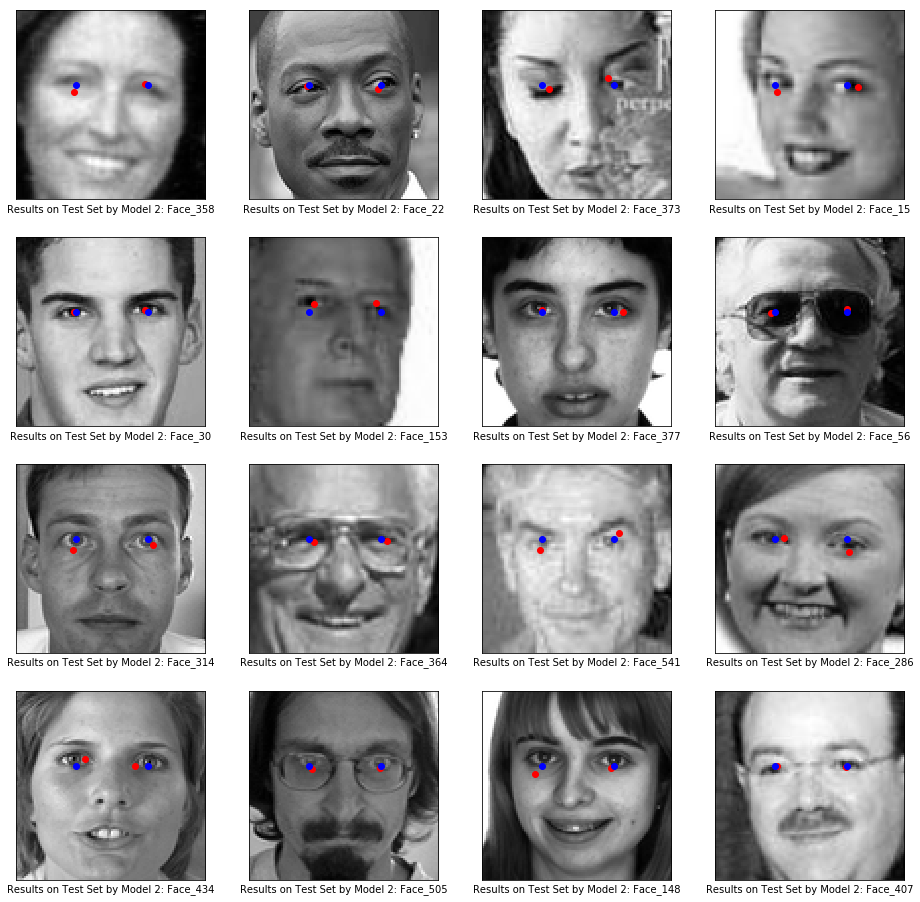

In [28]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    index = randint(0, 704)
    img = X_test[index].reshape(96, 96)
    landmark_x_original, landmark_y_original = get_coordinates(Y_train[index])
    landmark_x, landmark_y = get_coordinates(model_2.predict(X_test[index].reshape(1, 96, 96, 1))[0])
    ax.imshow(img, cmap = 'gray')
    ax.scatter(landmark_x_original, landmark_y_original, c = 'r')
    ax.scatter(landmark_x, landmark_y, c = 'b')
    ax.set_xlabel('Results on Test Set by Model 2: Face_' + str(index))
plt.show()

In [29]:
model_2.save('model_2.h5')